# Cell Type Prediction

There are different ways to predict cell types, e. g. using astir or argmax. Here, we demonstrate how to filter data and then use argmax to get a quick initial prediction.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import spatial_data
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
xr.set_options(display_style='text')

In [3]:
ds = xr.load_dataset('/g/huber/projects/CITEseq/CODEX/BNHL_TMA/bhnl_labeled_zarr/166_4_I2_LK_labeled.zarr')

/home/meyerben/meyerben/.conda/envs/spatialproteomics_env/lib/python3.9/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/meyerben/meyerben/.conda/envs/spatialproteomics_env/lib/python3.9/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [4]:
# preprocessing: filtering by percentiles and applying a median filter

# can specify channel specific quanitle thresholds here (or even sample specific thresholds)
ct_dict = {
    "B": dict(channel = 'PAX5', quantile = .8, color=spatial_data.Red),
    "T": dict(channel = 'CD3', quantile = .5, color=spatial_data.Green),
    "Myeloid": dict(channel = 'CD11b', quantile = .8, color=spatial_data.Yellow),
    "Dendritic": dict(channel = 'CD11c', quantile = .8, color=spatial_data.Blue),
    "Granulo": dict(channel = 'CD15', quantile = .8, color=spatial_data.Apricot),
    "Macro": dict(channel = 'CD68', quantile = .8, color=spatial_data.Orange),
    "Stroma PDPN": dict(channel = 'Podoplanin', quantile = .95, color=spatial_data.Purple),
    "Stroma CD31": dict(channel = 'CD31', quantile = .95, color=spatial_data.Beige),
    "Stroma CD34": dict(channel = 'CD34', quantile = .95, color=spatial_data.Teal),
    "Stroma CD90": dict(channel = 'CD90', quantile = .95, color=spatial_data.Pink),
    "NK": dict(channel = 'CD56', quantile = .8, color=spatial_data.Brown),
}

channels = [ v['channel'] for k, v in  ct_dict.items()]
quantiles = [ v['quantile'] for k, v in  ct_dict.items()]
colors = [ v['color'] for k, v in  ct_dict.items()]

ds_processed = ds.pp[channels].pp.filter(quantiles).pp.restore('medfilt2d', kernel_size=3)

Text(0.5, 1.0, 'Processed')

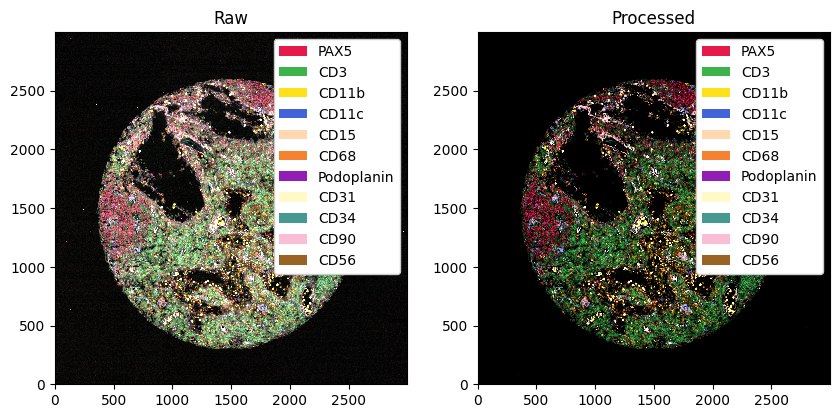

In [5]:
# plotting the ds and ds processed next to one another

# visualizing the raw vs the processed image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

_ = ds.pp[channels].pl.colorize(colors).pl.imshow(legend_background=True, ax=ax[0])
_ = ds_processed.pp[channels].pl.colorize(colors).pl.imshow(legend_background=True, ax=ax[1])

ax[0].set_title("Raw")
ax[1].set_title("Processed")

In [6]:
ct_marker_dict = dict(zip(ct_dict.keys(), channels))
ct_marker_dict

{'B': 'PAX5',
 'T': 'CD3',
 'Myeloid': 'CD11b',
 'Dendritic': 'CD11c',
 'Granulo': 'CD15',
 'Macro': 'CD68',
 'Stroma PDPN': 'Podoplanin',
 'Stroma CD31': 'CD31',
 'Stroma CD34': 'CD34',
 'Stroma CD90': 'CD90',
 'NK': 'CD56'}

In [7]:
# predicting the cell type using the argmay
ds_with_ct_predictions = ds_processed.la.predict_cell_types_argmax(ct_marker_dict, key='_arcsinh_mean', overwrite_existing_labels=True)

# adding colors to match the markers
print(list(ct_dict.keys()), colors)
ds_with_ct_predictions = ds_with_ct_predictions.la.set_label_colors(list(ct_dict.keys()), colors)

Label Stroma PDPN not found in the data object. Skipping.
Label Stroma CD31 not found in the data object. Skipping.


['B', 'T', 'Myeloid', 'Dendritic', 'Granulo', 'Macro', 'Stroma PDPN', 'Stroma CD31', 'Stroma CD34', 'Stroma CD90', 'NK'] ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#ffd8b1', '#f58231', '#911eb4', '#fffac8', '#469990', '#fabed4', '#9A6324']


Text(0.5, 1.0, 'Cell Type Predictions')

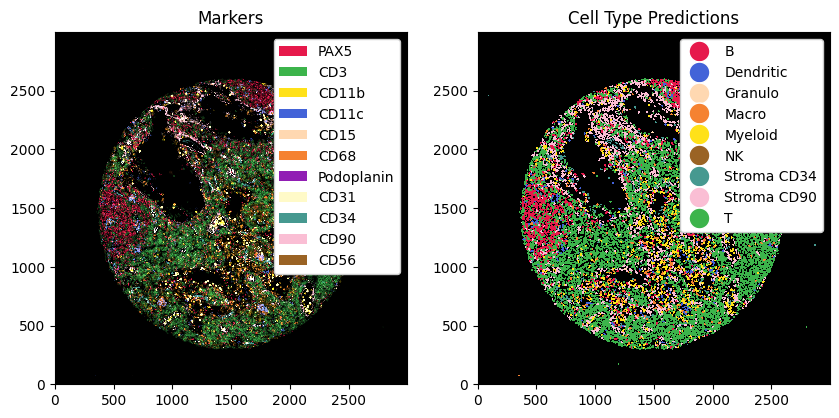

In [8]:
# plotting the ct predictions next to the processed image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

_ = ds_with_ct_predictions.pp[channels].pl.colorize(colors).pl.imshow(legend_background=True, ax=ax[0])
_ = ds_with_ct_predictions.pl.imshow(render_intensities=False, render_labels=True, legend_label=True, ax=ax[1])

ax[0].set_title("Markers")
ax[1].set_title("Cell Type Predictions")

# Marker Binarization

For some (functional) markers, we want to binarize them (i. e. is a cell positive or negative for that marker). This can be achieved with the `la.add_binarization` function.

In [82]:
# these thresholds are the percentiles, so they are between 0 and 100
threshold_dict = {
    "PAX5": 80,
    "CD3": 50
}

ds_with_binarization = ds_with_ct_predictions.la.add_binarization(threshold_dict, layer_key='_arcsinh_mean')
ds_with_binarization

/g/huber/users/meyerben/notebooks/codex_analysis/2024-03-18_spatialproteomics_package/spatial-data/spatial_data/la/label.py:13: AccessorRegistrationWarning: registration of accessor <class 'spatial_data.la.label.LabelAccessor'> under name 'la' for type <class 'xarray.core.dataset.Dataset'> is overriding a preexisting attribute with the same name.
  class LabelAccessor:


<xarray.Dataset>
Dimensions:        (labels: 9, props: 2, cells: 12560, channels: 11,
                    features: 6, x: 3000, y: 3000)
Coordinates:
  * labels         (labels) int64 1 2 3 4 5 6 7 8 9
  * props          (props) <U6 '_color' '_name'
  * cells          (cells) int64 1 2 3 4 5 6 ... 12556 12557 12558 12559 12560
  * channels       (channels) <U11 'PAX5' 'CD3' 'CD11b' ... 'CD34' 'CD90' 'CD56'
  * features       (features) <U14 'CD3_binarized' ... 'centroid-1'
  * x              (x) int64 0 1 2 3 4 5 6 ... 2994 2995 2996 2997 2998 2999
  * y              (y) int64 0 1 2 3 4 5 6 ... 2994 2995 2996 2997 2998 2999
Data variables:
    _arcsinh_mean  (cells, channels) float64 0.007447 2.46 ... 0.9805 0.0
    _arcsinh_sum   (cells, channels) float64 1.138 7.689 3.606 ... 6.204 0.0
    _obs           (cells, features) float64 1.0 0.0 9.0 ... 2.249e+03 2.237e+03
    _raw_mean      (cells, channels) float64 0.03723 29.06 0.4894 ... 5.727 0.0
    _raw_sum       (cells, channels) float64 7.0 5.463e+03 ... 1.237e+03 0.0
    _segmentation  (y, x) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    _image         (channels, y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    _labels        (labels, props) object '#e6194B' 'B' ... '#3cb44b' 'T'

/home/meyerben/meyerben/.conda/envs/spatialproteomics_env/lib/python3.9/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


Text(0.5, 1.0, 'CD3 binarization')

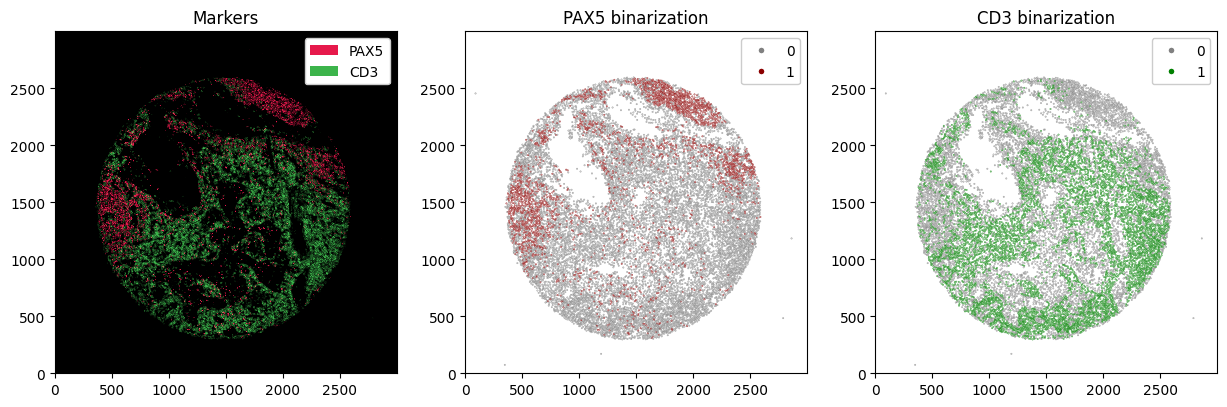

In [83]:
# plotting the binarization next to the marker intensities
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
_ = ds_with_binarization.pp[['PAX5', 'CD3']].pl.imshow(render_intensities=True, render_labels=False, legend_background=True, ax=ax[0])
_ = ds_with_binarization.pl.scatter(feature='PAX5_binarized', size=0.1, color_scheme={0: 'gray', 1: 'darkred'}, ax=ax[1])
_ = ds_with_binarization.pl.scatter(feature='CD3_binarized', size=0.1, color_scheme={0: 'gray', 1: 'green'}, ax=ax[2])

ax[0].set_title("Markers")
ax[1].set_title("PAX5 binarization")
ax[2].set_title("CD3 binarization")